In [1]:
# Kaggle or Colab
import sys
import os
if 'kaggle_web_client' in sys.modules:
    # Do something
    pass
elif 'google.colab' in sys.modules:
    # Do something
    from google.colab import drive
    drive.mount("/content/drive")

    comp_name_official = "chaii-hindi-and-tamil-question-answering"
    comp_name_local = "Kaggle-chaii"

    !pip install --upgrade --force-reinstall --no-deps kaggle
    import json
    f = open("/content/drive/MyDrive/colab_notebooks/kaggle/kaggle.json", "r")
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

    %cd /content/drive/MyDrive/colab_notebooks/kaggle/{comp_name_local}/notebooks

Mounted at /content/drive
     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=133a12f80490a1e947b8dd8647fb92e77f26b0149332b98b0cdcb1fbc520f5f5
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-chaii/notebooks


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/chaii-hindi-and-tamil-question-answering/test.csv
../input/chaii-hindi-and-tamil-question-answering/sample_submission.csv
../input/chaii-hindi-and-tamil-question-answering/train.csv


In [3]:
if 'kaggle_web_client' in sys.modules:
    # Do something
    pass
elif 'google.colab' in sys.modules:
    !pip install transformers

     |████████████████████████████████| 2.8 MB 7.0 MB/s 
     |████████████████████████████████| 895 kB 88.0 MB/s 
     |████████████████████████████████| 636 kB 81.4 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 3.3 MB 63.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import re

In [5]:
from transformers import AdamW
from transformers import get_scheduler
#from transformers import BertTokenizer, BertModel

In [6]:
from transformers import BertTokenizerFast

In [7]:
from transformers import BertForQuestionAnswering

In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
#model = BertModel.from_pretrained("bert-base-multilingual-cased")

# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

# reference: https://huggingface.co/bert-base-multilingual-cased

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [9]:
train = pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/train.csv")
train.head()

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil


In [37]:
# Text cleansing for context

#alphabets = "([A-Za-z])"
alphabets = "([\u0900-\u097F\u0B80-\u0BFF])" # Hindi & Tamil
prefixes = re.compile("(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)[.]")
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = re.compile("[.](co|net|org|io|gov|edu|us)")
etal = re.compile(r"(\bet al)[.]")
urls = re.compile("(www)[.]")
digits =  re.compile("[.]([0-9])")

def split_into_sentences(text):
    """
    This function will be applied to context in df
    ----------------------------------------------
    Args: 
        text: str
    Returns:
        sentences: List[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = prefixes.sub("\\1<prd>",text)
    text = websites.sub("<prd>\\1",text)
    text = urls.sub("\\1<prd>",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    text = etal.sub("\\1<prd>", text)
    text = digits.sub("<prd>\\1",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    if sentences[-1] == '':
        sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

def clean_text(txt, apply_space_norm=False, strip=False):
    """
    This function will be applied to question and answer in df
    ----------------------------------------------------------
    Args: 
        text: str
    Returns:
        text: str
    """
    txt = re.sub('\[[0-9]\]', '', txt) # remove Wikipedia's quotes
    if apply_space_norm:
        txt = re.sub('[^A-Za-z\u0900-\u097F\u0B80-\u0BFF0-9]+', ' ', str(txt).lower()) # Hindi: \u0900-\u097F, Tamil: \u0B80-\u0BFF
    if strip:
        txt = txt.strip()
    return txt


def shorten_sentences(sentences, max_length=512, overlap=60):
    """
    If a sentence is longer than `max_length`, break it into chunks of 
    length `max_length` with an overlap of length `overlap`.
    
    e.g. if the sentence has 50 tokens, max_length is 20, and overlap is 10.
    Then the first sentence will be token_i where i in [0,20)
    Second sentence will be token_i in [10,30).
    Third sentence [20, 40)
    Fourth [30, 50)
    Fifth [40, 60)
    ------------------------------------------------------------------------
    Args:
        sentences: List[str]
        max_length: int
        overlap: int
    Returns:
        shortend_sentences: List[str]
    """
    shortened_sentences = []
    for sentence in sentences:
        sentence = clean_text(sentence, apply_space_norm=True)
        words = sentence.split()
        num_words = len(words)
        if num_words > max_length:
            for start_index in range(0, num_words, max_length - overlap):
                shortened_sentences.append(' '.join(words[start_index:start_index+max_length]))
        else:
            shortened_sentences.append(sentence)
    return shortened_sentences

# refenrece:
# [1] https://stackoverflow.com/questions/41356013/how-to-detect-if-a-string-contains-hindi-devnagri-in-it-with-character-and-wor
# [2] https://en.wikipedia.org/wiki/Unicode_block
# [3] https://www.kaggle.com/nbroad/no-training-question-answering-model?scriptVersionId=66240356

In [11]:
train.head()

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil


In [33]:
train["context_sentences"] = train["context"].apply(clean_text).apply(split_into_sentences).apply(shorten_sentences)

In [34]:
train["context_sentences"]

0       [ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பி...
1       [காளிதாசன் தேவநாகரி कालिदास சமஸ்கிருத இலக்கியத...
2       [சர் அலெக்ஸாண்டர் ஃபிளெமிங் sir alexander flem...
3       [குழந்தையின் அழுகையை நிறுத்தவும் தூங்க வைக்கவு...
4       [சூரியக் குடும்பம் சூரியக் குடும்பம் solar sys...
                              ...                        
1109    [स्वामी निगमानन्द परमहंस 18 अगस्त 1880 29 नवम्...
1110    [भरत मुनि ने नाट्यशास्त्र नामक प्रसिद्ध ग्रन्थ...
1111    [अग्नि पंचम अग्नि ५ भारत की अन्तरमहाद्वीपीय बै...
1112    [जलाल उद्दीन मोहम्मद अकबर १५ अक्तूबर १५४२ २७ अ...
1113    [अमेरिका में जन्मीं अभिनेत्री तथा फैशन डिज़ाइन...
Name: context_sentences, Length: 1114, dtype: object

In [35]:
train.loc[2, "context_sentences"][-1]

'மேற்கோள்கள் வெளி இணைப்புகள் பகுப்பு 1881 பிறப்புகள் பகுப்பு நோபல் மருத்துவப் பரிசு பெற்றவர்கள் பகுப்பு ஆங்கிலேய அறிவியலாளர்கள் பகுப்பு இசுக்கொட்டிய அறிவியலாளர்கள் பகுப்பு 1955 இறப்புகள்'

In [36]:
train.loc[2, "context_sentences"][0]

'சர் அலெக்ஸாண்டர் ஃபிளெமிங் sir alexander fleming ஆகஸ்ட் 6 1881 மார்ச் 11 1955 நுண்ணுயிர் கொல்லியான சிதைநொதியைக் கண்டுபிடித்தவர் '

In [28]:
train.loc[2, "context_sentences"]

['சர் அலெக்ஸாண்டர் ஃபிளெமிங் sir alexander fleming ஆகஸ்ட் 6 1881 மார்ச் 11 1955 நுண்ணுயிர் கொல்லியான சிதைநொதியைக் கண்டுபிடித்தவர் ',
 'மேலும் நுண்ணுயிர் கொல்லியான பெனிசிலினை பெனிசிலியம் நொடேடம் penicillium notatum என்ற பூஞ்சையிலிருந்து பிரித்தெடுத்தார் ',
 'பெனிசிலின் கண்டுபிடிப்பு உலகம் அறிந்துள்ள மருத்துவ முன்னேற்றங்களுள் பெனிசிலின் கண்டுபிடிப்பு தனிச்சிறப்பு வாய்ந்தது ',
 'பெனிசிலின் காலத்திற்கு முன் பிரசவத்தில் பெண்கள் இறப்பதும் பிறந்தபின் குழந்தைகள் இறப்பதும் சர்வ சாதாரணம் ',
 'லேசான சிராய்ப்புகளும் கீறல்களும் கூட மரணத்திற்கு இட்டுச் சென்றன ',
 'ஒரு நுண்ணுயிரை வைத்து இன்னொன்றைக் கொல்லமுடிகிற பெனிஸிலின் போன்ற நச்சுமுறி மருந்துகள் கண்டுபிடிக்கப்பட்ட பிறகுதான் பல நோய்களிலிருந்து மனிதர்களைக் காப்பாற்ற முடிந்தது ',
 'பெனிசிலினைக் கண்டு பிடித்து நவீன நச்சுமுறி மருந்துகள் யுகத்தைத் தொடங்கிவைத்த பெருமைக்குரிய விஞ்ஞானிதான் அலெக் ஸாண்டர் ஃப்பௌமிங் ',
 'பெனிசிலின் உலகெங்கிலும் உள்ள 20 கோடி மக்களின் உயிரைக் காப்பாற்றியுள்ளது என்கிறது ஒரு மதிப்பீடு ',
 'பிறப்பு ஃப்ளெமிங் 1881 ஆகஸ்ட் 6 அன்று ஸ்

In [39]:
train["question"] = train["question"].apply(clean_text, apply_space_norm=True, strip=True)

In [43]:
train["answer_text"] = train["answer_text"].apply(clean_text, apply_space_norm=True, strip=True)

In [44]:
train

,id,context,question,answer_text,answer_start,language,context_sentences
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன,206,53,tamil,[ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பி...
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்,காசுமீரில்,2358,tamil,[காளிதாசன் தேவநாகரி कालिदास சமஸ்கிருத இலக்கியத...
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil,[சர் அலெக்ஸாண்டர் ஃபிளெமிங் sir alexander flem...
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil,[குழந்தையின் அழுகையை நிறுத்தவும் தூங்க வைக்கவு...
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது,சூரியனும்,585,tamil,[சூரியக் குடும்பம் சூரியக் குடும்பம் solar sys...
...,...,...,...,...,...,...,...
1109,26f356026,स्वामी निगमानन्द परमहंस (18 अगस्त 1880 - 29 नव...,स्वामी निगमानन्द परमहंस के तन्त्र गुरु कौन थे,बामाक्षेपा,2691,hindi,[स्वामी निगमानन्द परमहंस 18 अगस्त 1880 29 नवम्...
1110,31179f1bb,भरत मुनि ने नाट्यशास्त्र नामक प्रसिद्ध ग्रन्थ ...,नित्यशास्त्र किसने लिखा है,भरत मुनि,0,hindi,[भरत मुनि ने नाट्यशास्त्र नामक प्रसिद्ध ग्रन्थ...
1111,0d35dc007,अग्नि पंचम (अग्नि-५) भारत की अन्तरमहाद्वीपीय ब...,अग्नि पंचम ५ मिसाइल की लम्बाई कितने मीटर है,17,155,hindi,[अग्नि पंचम अग्नि ५ भारत की अन्तरमहाद्वीपीय बै...
1112,7f997884d,"जलाल उद्दीन मोहम्मद अकबर () (१५ अक्तूबर, १५४२-...",मुगल सम्राट अकबर की मृत्यु किस वर्ष में हुई थी,२७ अक्तूबर १६०५,46,hindi,[जलाल उद्दीन मोहम्मद अकबर १५ अक्तूबर १५४२ २७ अ...


In [45]:
train["context_string_length"] = train["context"].apply(lambda x: len(x))
train["context_token_length"] = train["context"].apply(lambda x: len(x.split()))
train.head()

,id,context,question,answer_text,answer_start,language,context_sentences,context_string_length,context_token_length
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன,206,53,tamil,[ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பி...,4340,512
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்,காசுமீரில்,2358,tamil,[காளிதாசன் தேவநாகரி कालिदास சமஸ்கிருத இலக்கியத...,7647,789
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil,[சர் அலெக்ஸாண்டர் ஃபிளெமிங் sir alexander flem...,4970,508
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil,[குழந்தையின் அழுகையை நிறுத்தவும் தூங்க வைக்கவு...,8493,941
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது,சூரியனும்,585,tamil,[சூரியக் குடும்பம் சூரியக் குடும்பம் solar sys...,9954,1113


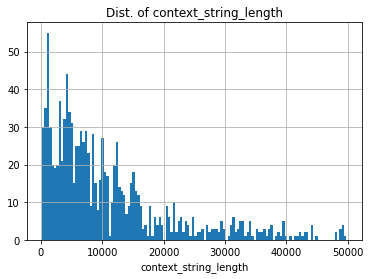

In [46]:
col = "context_string_length"
train[col].hist(bins=128)
plt.xlabel(f"{col}")
plt.title(f"Dist. of {col}");

num of obs w/ context_token_length being shorter than or equal to 512:
 246
num of obs w/ context_token_length being longer than 512:
 868


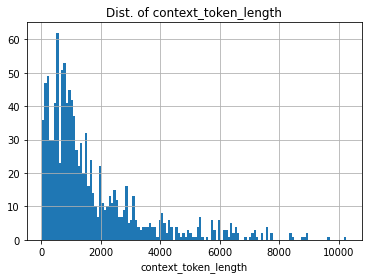

In [47]:
col = "context_token_length"
train[col].hist(bins=128)
plt.xlabel(f"{col}")
plt.title(f"Dist. of {col}");

print(f"num of obs w/ {col} being shorter than or equal to 512:\n", len(train[train[col]<=512]))
print(f"num of obs w/ {col} being longer than 512:\n", len(train[train[col]>512]))

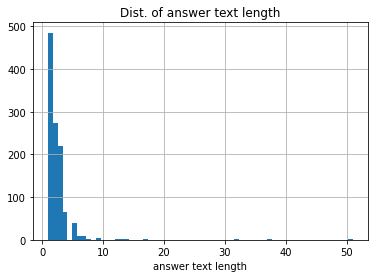

In [48]:
train["answer_text"].apply(lambda x: len(x.split())).hist(bins=64)
plt.xlabel("answer text length")
plt.title("Dist. of answer text length");

In [13]:
train[train["answer_text"].apply(lambda x: len(x.split()))>50]

,id,context,question,answer_text,answer_start,language,context_string_length,context_token_length
648,a4bccea58,२७ अगस्त २०१३ मुज़फ़्फ़र नगर जिले के कवाल गाँव...,मुज़फ़्फ़र नगर दंगा कब से कब तक चला था?,२७ अगस्त २०१३ मुज़फ़्फ़र नगर जिले के कवाल गाँव...,0,hindi,3702,696


In [14]:
train.loc[648, "context"]

'२७ अगस्त २०१३ मुज़फ़्फ़र नगर जिले के कवाल गाँव में जाट -मुस्लिम हिंसा के साथ यह दंगा शुरू हुआ जिसके कारण अब तक ४३ जाने जा चुकी है और ९३ हताहत हुए हैं। १७ सितम्बर को दंगा प्रभावित हर स्थानों से कर्फ्यु हटा लिया गया और सेना वापस बुला ली गयी।[5]\n शुरुआती झड़पें \nजाट और मुस्लिम समुदाय के बीच २७ अगस्त २०१३ से प्रारंभ हुई। कवाल गाँव में कथित तौर पर एक जाट समुदाय लड़की के साथ एक मुस्लिम युवक की छेड़खानी के साथ यह मामला शुरू हुआ।[6] उसके बाद लड़की के परिवार के दो ममेरे भाइयों गौरव और सचिन ने शाहनवाज नाम के युवक को पीट-पीट कर मार डाला को मार डाला। उसके बाद मुस्लिमों ने दोनों युवकों को जान से मार डाला। इसके बाद पुलिस ने दोनों तरफ के लोगों को गिरफ्तार कर लिया। [7]\nइस खबर के फैलते ही मुज़फ़्फ़र नगर, शामली, बागपत, सहारनपुर में दंगा फ़ैल गया।[8]\n जनसभा \nइसके दोनों तरफ से राजनीति शुरु हो गई। मारे गए दोनों जाटो युवकों के इंसाफ के लिए एक महापंचायत बुलाई गई। इसके बाद मुस्लिमों की तरफ से ३० अगस्त को हुई मुस्लिम महापंचायत हुई। उसके जवाब में हुई नंगला मंदौड़ में हुई महापंचायत में भारतीय जनता पार्टी क

In [15]:
train.loc[648, "answer_text"]

'२७ अगस्त २०१३ मुज़फ़्फ़र नगर जिले के कवाल गाँव में जाट -मुस्लिम हिंसा के साथ यह दंगा शुरू हुआ जिसके कारण अब तक ४३ जाने जा चुकी है और ९३ हताहत हुए हैं। १७ सितम्बर को दंगा प्रभावित हर स्थानों से कर्फ्यु हटा लिया गया और सेना वापस बुला ली गयी।'

In [16]:
train["answer_start"].min()

0

In [17]:
train[train["answer_text"]=="IBM"]

,id,context,question,answer_text,answer_start,language,context_string_length,context_token_length
5,d419db018,மின்னணுவியல் (Electronics) மின்னணுக்கள் அல்லது...,திரிதடையங்களைப் பயன்படுத்திய முதல் நிறுவனம் எது?,IBM,4171,tamil,8796,833


In [18]:
context_5 = train.loc[5, "context"]
context_5

'மின்னணுவியல் (Electronics) மின்னணுக்கள் அல்லது மின்னன்கள் வழி மின் ஆற்றலைக் கட்டுபடுத்தும் அறிவியல் புலமாகும். இலத்திரனியல் அல்லது மின்னணுவியல் மின்குமிழ், கடிகாரம், தொலைபேசி, வானொலி, தொலைக்காட்சி, கணினி போன்ற அன்றாட வாழ்வில் பயன்படும் பல கருவிகளின் இயக்கத்துக்குப் பயன்படும் அடிப்படைத் தொழில்நுட்பம் ஆகும். மின்னணுவியல் தகவல்களைத் தேக்கவும் கையாளவும்  பயன்படுகிறது. அதாவது, மின்ஆற்றலைக் கொண்டு மின்குறிகைகளை உருவாக்கலாம். மின்குறிகைகளால்  தகவல்களை பதிலீடு செய்யலாம். இந்த மின்குறிகைகளை அல்லது தகவல்களை மின்னணுவியல் கருவிகளால் தேக்கலாம் அல்லது கணிக்கலாம்.\nஇந்தப் புலத்தில் வெற்றிடக் குழல்கள், திரிதடையங்கள், இருமுனையங்கள்,  நுண் தொகுப்புச்சுற்றுக்களும் ஒளிமின்னன் கருவிகளும் உணரிகளும் போன்ற செயல்படு மின்கூறுகளும் மின்தடையம், மின்தேக்கி,  மின்தூண்டிகள் போன்ற செயலறு மின்கூறுகளால் ஆகிய மின்சுற்றுகளும் பெரும் பங்காற்றுகின்றன. எனவே பொதுவாக மின்னனியல் கருவிகளில் செயல்முனைவான அரைக்கடத்திகளும் செயலறு மின்சுற்று உறுப்புகளும் அமையும். இந்தச் சுற்றே மின்னணுவியல் சுற்று எனப்படுகிறது. மின்னணுவியல் இயற்பிய

In [19]:
answer_text_5 = train.loc[5, "answer_text"]
answer_text_5

'IBM'

In [20]:
# Get the string-wise start position of answer_text
substring_start_pos = context_5.find(answer_text_5)
print(substring_start_pos)

4171


In [21]:
# ToDo:
# Get the token-wise start position of answer_text
tokenwise_start_pos = len(context_5[:substring_start_pos+1].split()) - 1
print(tokenwise_start_pos)

380


In [22]:
context_5.split()[tokenwise_start_pos]

'IBM'

In [23]:
#train["answer_start_check"] = np.nan
train["answer_start_tw"] = 0 # token-wise answer start position
for i,row in train.iterrows():
    row_context_find_answer_text = row["context"].find(row["answer_text"])
    row_answer_start = row["answer_start"]

    if row_context_find_answer_text != row_answer_start:
        raise ValueError("An inaccurate answer_start found!")
    
    train.loc[i, "answer_start_tw"] = len(row["context"][:row_answer_start+1].split()) - 1

In [24]:
#train[train["answer_start"] != train["answer_start_check"]]

In [25]:
train.loc[5, :]

id                                                               d419db018
context                  மின்னணுவியல் (Electronics) மின்னணுக்கள் அல்லது...
question                  திரிதடையங்களைப் பயன்படுத்திய முதல் நிறுவனம் எது?
answer_text                                                            IBM
answer_start                                                          4171
language                                                             tamil
context_string_length                                                 8796
context_token_length                                                   833
answer_start_tw                                                        380
Name: 5, dtype: object

In [26]:
train["answer_start_tw"].min()

0

In [27]:
# As [CLS] token to be prepended at the very first position
train["answer_start_tw"] = train["answer_start_tw"] + 1
train["answer_start_tw"].min()

1

**最大512長で分割**<br><br>

The hack is to split the clinical notes into multiple sub-notes such that every sub-note when concatenated with input question, gives close to 512 tokens. After concatenating the input question with sub-note, there are two possibilities: 1) if sub-note contains the ground truth answer, label the answer with its start and end position in sub-note 2) if sub-note does not contain ground truth answer, label the start and end position as 0 (points to [CLS] token).<br><br>
reference: [Adapting BERT question answering for the medical domain](https://medium.com/analytics-vidhya/adapting-bert-question-answering-for-the-medical-domain-2085ada8ceb1)

オーバーラップは60 tokens とする.

In [28]:
# max_len = 512
# context_len = 5121
# overlap=60

# for i in range(0, context_len, max_len-overlap):
#     print("start_position:", i)
#     print("end_position:", min(i + max_len, context_len-1))
#     print()

In [29]:
# for i in range(10):
#     if i%2==0:
#         pass
#     else:
#         i *= 100
#     print(i)

In [30]:
def read_chaii(df, max_len=512, overlap=60):
    """
    Args:
        df: pd.DataFrame
        max_len: int --default 512
        overlap: int --default 60
    Returns:
        contexts: List[str]
        questions: List[str]
        answers: List[Dict[str:int]]
    """
    #contexts = df["context"].tolist()
    #questions = df["question"].tolist()
    
    contexts = []
    questions = []
    answers = []
    for i,row in df.iterrows():
        context = row["context"]
        context_len = len(context.split())
        question = row["question"]
        
        #answer = {}
        #answer = {"text":[], "answer_start":[], "answer_end":[]}
        #answer["text"] = row["answer_text"]
        row_answer_text = row["answer_text"]
        row_answer_start = row["answer_start_tw"]
        row_answer_end = row_answer_start + len(row_answer_text.split()) - 1
        
        for j in range(0, context_len, max_len-overlap):
            contexts.append(context)
            questions.append(question)

            span_start_pos = j
            span_end_pos = min(j + max_len, context_len-1)
            if (span_start_pos <= row_answer_start-1) & (row_answer_end-1 <= span_end_pos):
                pass
            else:
                row_answer_start = 0 # [CLS] token position
                row_answer_end = 0 # [CLS] token position
            #answer["text"].append(row_answer_text)
            #answer["answer_start"].append(row_answer_start)
            #answer["answer_end"].append(row_answer_end)
            answer = {}
            answer["text"] = row_answer_text
            answer["answer_start"] = row_answer_start
            answer["answer_end"] = row_answer_end
            answers.append(answer)

    return contexts, questions, answers

In [31]:
train_contexts, train_questions, train_answers = read_chaii(train)

In [32]:
n = 20
train_contexts[:n]

['ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின்வரும் 206 (மார்பெலும்பு மூன்று பகுதிகளாகக் கருதப்பட்டால் 208) எண்ணிக்கையான எலும்புகளைக் கொண்டிருக்கும். இந்த எண்ணிக்கை உடற்கூட்டியல் வேறுபாடுகளைப் பொறுத்து மாறுபடக்கூடும். எடுத்துக்காட்டாக, மிகக் குறைந்த எண்ணிக்கையான மனிதர்களில், ஒரு மேலதிக விலா எலும்பு (கழுத்துவில்) அல்லது ஒரு மேலதிகமான கீழ் முதுகெலும்பு காணப்படுவதுண்டு; இணைந்த சில எலும்புகளைத் தனி எலும்பாகக் கருதாவிடின், ஐந்து இணைந்த திருவெலும்பு; மூன்று (3 - 5) குயிலலகு எலும்புகள் சேர்ந்து 26 எண்ணிக்கையிலான முதுகெலும்புகள் 33 ஆகக் கருதப்படலாம்.\nமனித மண்டையோட்டில் 22 எலும்புகள் (காதுச் சிற்றென்புகளைத் தவிர) உள்ளன; இவை எட்டு மண்டையறை (cranium) எலும்புகளாகவும் 14 முக எலும்புகளாகவும் (facial bones) பிரிக்கப்பட்டுள்ளன. (தடித்த எண்கள் அருகிலுள்ள படத்தில் காணும் எண்களைக் குறிக்கின்றன.)\n\n\n\nமண்டையறை எலும்புகள் (8)\n 1 நுதலெலும்பு (frontal bone) \n 2 சுவரெலும்பு (parietal bone) (2)\n 3 கடைநுதலெலும்பு (temporal bone) (2)\n 4 பிடர் எலும்பு (occipital bone)\n ஆப்புரு எலும்பு (sphenoid bone)\n

In [33]:
train_questions[:n]

['மனித உடலில் எத்தனை எலும்புகள் உள்ளன?',
 'மனித உடலில் எத்தனை எலும்புகள் உள்ளன?',
 'காளிதாசன் எங்கு பிறந்தார்?',
 'காளிதாசன் எங்கு பிறந்தார்?',
 'பென்சிலின் கண்டுபிடித்தவர் யார்?',
 'பென்சிலின் கண்டுபிடித்தவர் யார்?',
 'தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பாடல் எவ்வாறு அழைக்கப்படுகிறது?',
 'தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பாடல் எவ்வாறு அழைக்கப்படுகிறது?',
 'தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பாடல் எவ்வாறு அழைக்கப்படுகிறது?',
 'பூமியின் அருகில் உள்ள விண்மீன் எது?',
 'பூமியின் அருகில் உள்ள விண்மீன் எது?',
 'பூமியின் அருகில் உள்ள விண்மீன் எது?',
 'திரிதடையங்களைப் பயன்படுத்திய முதல் நிறுவனம் எது?',
 'திரிதடையங்களைப் பயன்படுத்திய முதல் நிறுவனம் எது?',
 'தொலைபேசியைக் கண்டுபிடித்தவர் யார்?',
 'தொலைபேசியைக் கண்டுபிடித்தவர் யார்?',
 'தொலைபேசியைக் கண்டுபிடித்தவர் யார்?',
 'தொலைபேசியைக் கண்டுபிடித்தவர் யார்?',
 'முதலாம் உலகப்போர் எப்பொழுது துவங்கியது?',
 'முதலாம் உலகப்போர் எப்பொழுது துவங்கியது?']

In [34]:
n = 200
train_answers[:n]

[{'answer_end': 7, 'answer_start': 7, 'text': '206'},
 {'answer_end': 0, 'answer_start': 0, 'text': '206'},
 {'answer_end': 251, 'answer_start': 251, 'text': 'காசுமீரில்'},
 {'answer_end': 0, 'answer_start': 0, 'text': 'காசுமீரில்'},
 {'answer_end': 3, 'answer_start': 1, 'text': 'சர் அலெக்ஸாண்டர் ஃபிளெமிங்'},
 {'answer_end': 0, 'answer_start': 0, 'text': 'சர் அலெக்ஸாண்டர் ஃபிளெமிங்'},
 {'answer_end': 8, 'answer_start': 8, 'text': 'தாலாட்டு'},
 {'answer_end': 0, 'answer_start': 0, 'text': 'தாலாட்டு'},
 {'answer_end': 0, 'answer_start': 0, 'text': 'தாலாட்டு'},
 {'answer_end': 56, 'answer_start': 56, 'text': 'சூரியனும்'},
 {'answer_end': 0, 'answer_start': 0, 'text': 'சூரியனும்'},
 {'answer_end': 0, 'answer_start': 0, 'text': 'சூரியனும்'},
 {'answer_end': 381, 'answer_start': 381, 'text': 'IBM'},
 {'answer_end': 0, 'answer_start': 0, 'text': 'IBM'},
 {'answer_end': 3, 'answer_start': 1, 'text': 'அலெக்ஸாண்டர் கிரகாம் பெல்'},
 {'answer_end': 0, 'answer_start': 0, 'text': 'அலெக்ஸாண்டர் கிரகா

In [35]:
train[train["answer_text"]=="1623"]

,id,context,question,answer_text,answer_start,language,context_string_length,context_token_length,answer_start_tw
60,a5ddec2d9,ஜலாலுதீன் முகமது அக்பர் (உருது: جلال الدین محم...,இந்தியப் பேரரசர் அக்பர் எப்போது இறந்தார்?,1623,24511,tamil,49815,5791,2873


In [37]:
context_60 = train.loc[60, "context"]

In [38]:
answer_text_60 = train.loc[60, "answer_text"]

In [40]:
context_60[24511:24511+4]

'1623'

In [44]:
context_60[24511:24511+6]

'1623-ல'

In [47]:
context_60.split()[2872]

'1623-ல்'

In [41]:
context_60.split()

['ஜலாலுதீன்',
 'முகமது',
 'அக்பர்',
 '(உருது:',
 'جلال',
 'الدین',
 'محمد',
 'اکبر,',
 'ஜலால்',
 'உத்-தீன்',
 'முகம்மத்',
 'அக்பர்),',
 'அல்லது',
 'பேரரசர்',
 'அக்பர்',
 '(Akbar,',
 '15',
 'அக்டோபர்',
 '1542',
 '–',
 '27',
 'அக்டோபர்',
 '1605),[3][4]',
 'முகலாயப்',
 'பேரரசின்',
 'மன்னராக',
 '1556',
 'முதல்',
 'இறக்கும்',
 'வரை',
 'பதவியில்',
 'இருந்தவர்.',
 'ஹிமாயுன்,',
 'ஹமீதா',
 'பானு',
 'இவர்களுக்கு',
 'பிறந்தவர்',
 'தான்',
 'அக்பர்,',
 'இவரது',
 'தந்தை',
 'மன்னர்',
 'நசிருதீன்',
 'ஹுமாயூன்',
 'இறந்ததை',
 'அடுத்து',
 'தனது',
 '13வது',
 'அகவையில்',
 'ஆட்சிக்கு',
 'வந்தார்.',
 'இவரே',
 'முகலாயப்',
 'பேரரசின்',
 'மன்னர்களுள்',
 'மிகவும்',
 'புகழ்',
 'பெற்றவர்',
 'எனக்',
 'கருதப்படுபவர்.',
 'இவரின்',
 'இயற்பெயர்',
 'ஜலாலுதீன்',
 'அக்பர்',
 '[5][6].',
 'இவரது',
 'ஆட்சிக்',
 'காலத்தில்',
 'ஆப்கானிய',
 'மன்னர்',
 'ஷேர்',
 'ஷா',
 'சூரியின்',
 'வழித்தோன்றல்களின்',
 'இராணுவத்',
 'தாக்குதல்களை',
 'முறியடித்தார்.',
 'முகலாயப்',
 'பேரரசுப்',
 'படைகள்',
 'இந்தியாவின்',
 'சூர்',
 'பேரரசின்',
 'தளப

**PyTorch Dataset & DataLoader**<br>
reference: https://huggingface.co/transformers/custom_datasets.html#question-answering-with-squad-2-0

In [11]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)

In [12]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [13]:
add_token_positions(train_encodings, train_answers)
# reference: https://www.gitmemory.com/issue/huggingface/transformers/12201/862549850
# "Why not use tokenizerfast?"

In [14]:
class ChaiiDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [15]:
train_dataset = ChaiiDataset(train_encodings)

In [16]:
# class ChaiiDataset(Dataset):
#     def __init__(self, df):
#         self.df = df

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         item = dict()
#         # item["context"] = torch.tensor(tokenizer(self.df.loc[idx, "context"], trucation=True, padding=True))
#         # item["question"] = torch.tensor(tokenizer(self.df.loc[idx, "question"], trucation=True, padding=True))
#         # item["label"] = torch.tensor(tokenizer(self.df.loc[idx, "label"], trucation=True, padding=True))
#         item["context"] = self.df.loc[idx, "context"]
#         item["question"] = self.df.loc[idx, "question"]
#         item["label"] = self.df.loc[idx, "label"]

#         return item

In [17]:
#train_dataset = ChaiiDataset(train)

In [16]:
# batch_size=16
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

Train

In [17]:
# Model
model = BertForQuestionAnswering.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-bas

In [18]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [20]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
model.eval()

100%|██████████| 420/420 [03:09<00:00,  2.77it/s]

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [21]:
print("Done")

Done


In [24]:
outputs

QuestionAnsweringModelOutput([('loss',
                               tensor(0.5376, device='cuda:0', grad_fn=<DivBackward0>)),
                              ('start_logits',
                               tensor([[-5.0803, -1.9683, -5.7525,  ..., -6.0948, -5.9726, -5.1051],
                                       [-2.0357, -3.0965, -5.7402,  ..., -6.0322, -5.6647, -5.0965]],
                                      device='cuda:0', grad_fn=<CopyBackwards>)),
                              ('end_logits',
                               tensor([[-5.5008, -6.7952, -7.0218,  ..., -6.8007, -6.7761, -5.8546],
                                       [-2.0236, -4.6653, -6.0392,  ..., -6.0004, -6.6836, -5.1846]],
                                      device='cuda:0', grad_fn=<CopyBackwards>))])

In [25]:
outputs[0]

tensor(0.5376, device='cuda:0', grad_fn=<DivBackward0>)

In [26]:
outputs.loss

tensor(0.5376, device='cuda:0', grad_fn=<DivBackward0>)

In [28]:
outputs.start_logits.shape

torch.Size([2, 512])

In [29]:
outputs.end_logits.shape

torch.Size([2, 512])

In [30]:
len(outputs)

3

In [1]:
#pred_start_positions = torch.argmax(outputs.start_logits, dim=-1)
#pred_end_positions = torch.argmax(outputs.end_logits, dim=-1)

NameError: ignored

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))